In [1]:
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
shap.initjs()

C:\Users\jlesl\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\jlesl\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
df = pd.read_csv("./data/super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [3]:
spare = pd.read_csv("./data/super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

In [4]:
n_matches = len(df[(df['Home Score']==0) & (df['Away Score']==0)])

In [5]:
df.head(n_matches)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,2020-02-28 00:00:00,Highlanders,Rebels,0,0,1.16,25.72,5.14,11
1,2020-02-28 00:00:00,Waratahs,Lions,0,0,1.58,22.19,2.42,11
2,2020-02-29 00:00:00,Hurricanes,Sunwolves,0,0,1.01,50.80,19.30,11
3,2020-02-29 00:00:00,Reds,Sharks,0,0,1.84,21.18,1.98,11
4,2020-02-29 00:00:00,Stormers,Blues,0,0,1.30,22.39,3.55,11
5,2020-02-29 00:00:00,Bulls,Jaguares,0,0,2.25,21.62,1.66,11


---
## 1. Cleaning and feature engineering
  - TO DO: Engineer more features which capture form, attack, defense etc

### Get win streak

In [6]:
def bool_to_int(bool_val):
    if bool_val:
        return 1
    else:
        return -1

def get_home_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Home Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try: 
        last_result = bool_to_int(next(results)[-1])
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak
        

def get_away_streak(team, date):
    
    date_df = df[df['Date'] < date]
    team_df = date_df[date_df['Away Team']==team].sort_values('Date', ascending=False)
    results = team_df.itertuples()
    try:
        last_result = bool_to_int(next(results)[-1])*-1
        streak = last_result
    except:
        streak = 0
    
    while True:
        try:
            next_result = bool_to_int(next(results)[-1])*-1
            if next_result == last_result:
                streak += next_result
            else:
                break
        except:
            break
    
    return streak

### Encode teams and add home / away streaks

In [7]:
countries = {'Crusaders': 'NZ',
             'Chiefs': 'NZ',
             'Blues': 'NZ',
             'Hurricanes': 'NZ',
             'Highlanders': 'NZ',
             'Bulls': 'SA',
             'Cheetahs': 'SA',
             'Kings': 'SA',
             'Lions': 'SA',
             'Sharks': 'SA',
             'Stormers': 'SA',
             'Brumbies': 'AUS',
             'Force': 'AUS',
             'Rebels': 'AUS',
             'Reds': 'AUS',
             'Waratahs': 'AUS',
             'Jaguares': 'ARG',
             'Sunwolves': 'JPN'}

def cleanup(df):
    
    # convert Date to datetime
    df['Date'] = pd.to_datetime(df.Date)
    
    # create response variable
    df['home_margin'] = df['Home Score'] - df['Away Score']
    
    # create home_win column
    df['home_win'] = (df['Home Score'] > df['Away Score'])
    
    df.drop(['Home Score', 'Away Score'], axis=1, inplace=True)
    
    # create home_streak and away_streak columns
    home_streaks = []
    away_streaks = []
    for row in df.itertuples():
        home_team = row[2]
        away_team = row[3]
        date = row[1]
        home_streaks.append(get_home_streak(home_team, date))
        away_streaks.append(get_away_streak(away_team, date))
        
    df['home_streak'] = home_streaks
    df['away_streak'] = away_streaks
    
    # add nationalities
    df['home_nationality'] = df['Home Team'].replace(countries)
    df['away_nationality'] = df['Away Team'].replace(countries)
    
    # encode nationalities
    df = pd.get_dummies(df, prefix='home_country', columns=['home_nationality'])
    df = pd.get_dummies(df, prefix='away_country', columns=['away_nationality'])
    
    # encode team names
    df = pd.get_dummies(df, prefix='home_team', columns=['Home Team'])
    df = pd.get_dummies(df, prefix='away_team', columns=['Away Team'])
    
    # aggregate odds into single probability variable
    df['home_odds'] = df['Away Odds'] / (df['Home Odds'] + df['Away Odds'])
    
    # drop irrelevent columns
    df.drop(['Date', 'Home Odds', 'Draw Odds', 'Away Odds',
             'home_country_ARG', 'home_country_JPN', 'away_country_ARG',
             'away_country_JPN', 'home_team_Cheetahs', 'away_team_Cheetahs',
             'home_team_Kings', 'away_team_Kings', 'home_team_Force',
             'away_team_Force'], 
            axis=1,
            inplace=True)
    
    return df

In [8]:
df = cleanup(df)
df.head()

,Bookmakers Surveyed,home_margin,home_win,home_streak,away_streak,home_country_AUS,home_country_NZ,home_country_SA,away_country_AUS,away_country_NZ,...,away_team_Hurricanes,away_team_Jaguares,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs,home_odds
0,11,0,False,-1,-3,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0.815873
1,11,0,False,-1,-4,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.605000
2,11,0,False,4,-6,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0.950271
3,11,0,False,2,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.518325
4,11,0,False,4,2,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0.731959


In [9]:
X = df[n_matches:].drop(['home_margin', 'home_win'], axis=1)
y = df[n_matches:].home_margin.values

In [10]:
# we will use these later:
X_temp = df[:n_matches].drop(['home_margin', 'home_win'], axis=1)
y_temp = df[:n_matches].home_margin.values

In [11]:
y.shape

(1372,)

In [12]:
X.shape

(1372, 40)

---
## 2. Train model
  - To do: train neural network using embeddings for teams instead of one-hot encoding

In [13]:
# set up train/test split with 80/20 proportion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)

In [14]:
model = XGBRegressor(max_depth=1, learning_rate=.1, n_estimators=100, n_jobs=-1, min_child_weight=5, subsample=.45, random_state=0)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.45, tree_method=None,
             validate_parameters=False, verbosity=None)

### Evaluate performance

In [15]:
# training data
print(f'Train RMSE: {np.sqrt(mean_squared_error(model.predict(X_train), y_train)):.3f}')
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.3f}')

Train RMSE: 14.385
Train MAE: 11.062


In [16]:
# test data
print(f'Test RMSE: {np.sqrt(mean_squared_error(model.predict(X_test), y_test)):.3f}')
print(f'Test MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}')

Test RMSE: 14.264
Test MAE: 10.771


### Train on all data (if not overfitting)

In [17]:
model.fit(X, y)

print(f'RMSE: {np.sqrt(mean_squared_error(model.predict(X), y)):.3f}')
print(f'MAE: {mean_absolute_error(y, model.predict(X)):.3f}')

RMSE: 14.353
MAE: 11.039


### SHAP values
[Here is a nice notebook tutorial](https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html)  for working with SHAP values.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


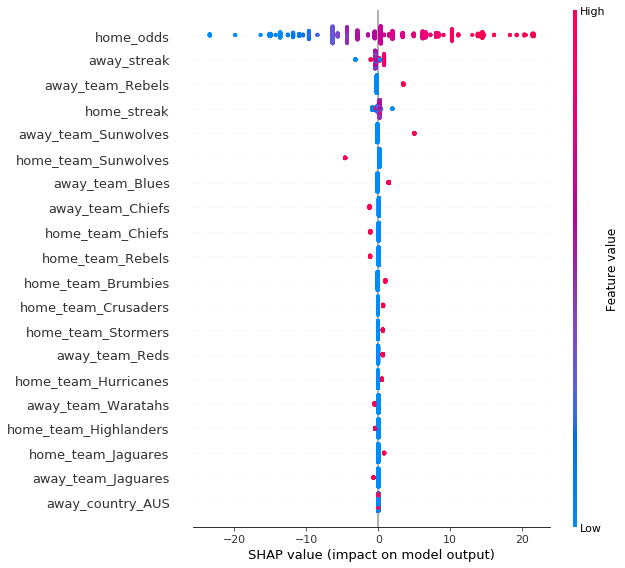

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

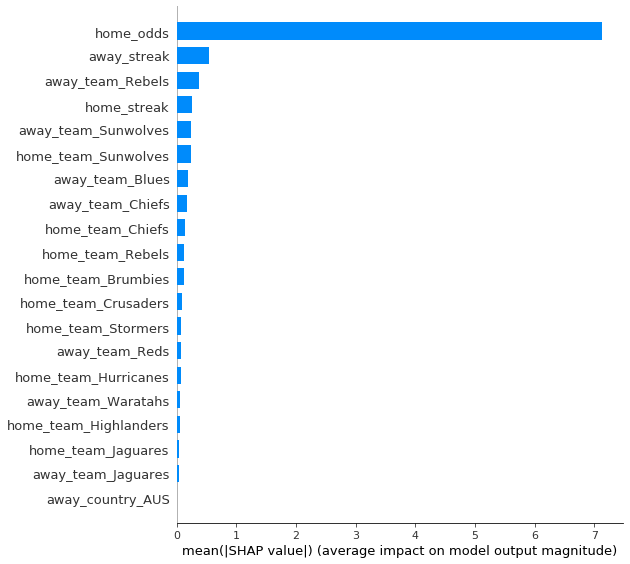

In [19]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [20]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

## 3. Make predictions for upcoming week

In [21]:
# predict for upcoming week
np.vstack((model.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

array([[17.224197387695312, 'Highlanders', 'Rebels'],
       [3.2892093658447266, 'Waratahs', 'Lions'],
       [31.783639907836914, 'Hurricanes', 'Sunwolves'],
       [0.9216527938842773, 'Reds', 'Sharks'],
       [10.919819831848145, 'Stormers', 'Blues'],
       [-3.521061420440674, 'Bulls', 'Jaguares']], dtype=object)

In [22]:
temp = np.vstack((model.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

In [23]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [24]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df

,Home_Margin,Home_Team,Away_Team
0,17,Highlanders,Rebels
1,3,Waratahs,Lions
2,32,Hurricanes,Sunwolves
3,1,Reds,Sharks
4,11,Stormers,Blues
5,-4,Bulls,Jaguares


### Explain single prediction

In [26]:
MATCH_NO = 2

print(f'Explaining result of  {preds_df.iloc[MATCH_NO,1]} vs {preds_df.iloc[MATCH_NO,2]}:\n')
shap_values = explainer.shap_values(X_temp)
shap.force_plot(explainer.expected_value, shap_values[MATCH_NO,:], X_temp.iloc[MATCH_NO,:])

Explaining result of  Hurricanes vs Sunwolves:

